<a href="https://colab.research.google.com/github/TollanBerhanu/ML-Leukemia-Disease-Classification/blob/main/Leukemia_Disease_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Leukemia Disease Classification Model

In this notebook we shall examine a small gene expression dataset, attempting to classify leukemia patients into one of two classes. This dataset comes from a proof-of-concept study published in 1999 by Golub et al. These data were used to classify patients with acute myeloid leukemia (AML) and acute lymphoblastic leukemia (ALL).

In [27]:
# Import all the libraries that are used in this notebook
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
# from sklearn.svm import SVC
# from sklearn.naive_bayes import GaussianNB

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

Let's start by taking a look at our target, the ALL/AML label.

In [6]:
# Import labels (for the whole dataset, both training and testing)
y = pd.read_csv('./kaggle_dataset/actual.csv')
print(y.shape)
y.head()

(72, 2)


,patient,cancer
0,1,ALL
1,2,ALL
2,3,ALL
3,4,ALL
4,5,ALL


We actually need our labels to be numeric, so let's just do that now.

In [3]:
# Recode label to numeric
y = y.replace({'ALL':0,'AML':1})
labels = ['ALL', 'AML'] # for plotting convenience later on

Now we move on to the features, which are provided for the training and testing datasets separately.

In [5]:
# Import training data
df_train = pd.read_csv('./kaggle_dataset/data_set_ALL_AML_train.csv')
print(df_train.shape)

# Import testing data
df_test = pd.read_csv('./kaggle_dataset/data_set_ALL_AML_independent.csv')
print(df_test.shape)

(7129, 78)
(7129, 70)


The 7129 gene descriptions are provided as the rows and the values for each patient as the columns. This will clearly require some tidying up.

Our first decision is: What should we do about all the "call" columns, one for each patient. No explanation for these is provided, so it's difficult to know whether they might be useful or not. We have taken the decision to simply remove them, but this may possibly not be the best approach.

In [7]:
# Transform all the call values to numbers (not used in this version)
# df_train.replace(['A','P','M'],['1','2','3'], inplace=True)
# df_test.replace(['A','P','M'],['1','2','3'], inplace=True)

# Remove "call" columns from training and testing data
train_to_keep = [col for col in df_train.columns if "call" not in col]
test_to_keep = [col for col in df_test.columns if "call" not in col]

X_train_tr = df_train[train_to_keep]
X_test_tr = df_test[test_to_keep]

Neither the training and testing column names are not in numeric order, so it's important that we reorder these at some point, so that the labels will line up with the corresponding data.

In [8]:
train_columns_titles = ['Gene Description', 'Gene Accession Number', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', 
       '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38']

X_train_tr = X_train_tr.reindex(columns=train_columns_titles)

test_columns_titles = ['Gene Description', 'Gene Accession Number','39', '40', '41', '42', '43', '44', '45', '46',
       '47', '48', '49', '50', '51', '52', '53',  '54', '55', '56', '57', '58', '59',
       '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72']

X_test_tr = X_test_tr.reindex(columns=test_columns_titles)

Now we can simply transpose the columns and rows so that genes become features and each patient's observations occupies a single row.

In [ ]:
X_train = X_train_tr.T
X_test = X_test_tr.T

print(X_train.shape) 
X_train.head()

This is still messy as the first two rows are more or less duplicates of one another and we haven't yet created the column names. Let's simply turn the second row into the column names and delete the first row.

In [10]:
# Clean up the column names for training and testing data
X_train.columns = X_train.iloc[1]
X_train = X_train.drop(["Gene Description", "Gene Accession Number"]).apply(pd.to_numeric)

# Clean up the column names for Testing data
X_test.columns = X_test.iloc[1]
X_test = X_test.drop(["Gene Description", "Gene Accession Number"]).apply(pd.to_numeric)

print(X_train.shape)
print(X_test.shape)
X_train.head()

(38, 7129)
(34, 7129)


Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
1,-214,-153,-58,88,-295,-558,199,-176,252,206,...,185,511,-125,389,-37,793,329,36,191,-37
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,169,837,-36,442,-17,782,295,11,76,-14
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,315,1199,33,168,52,1138,777,41,228,-41
4,-135,-114,265,12,-419,-585,158,-253,49,31,...,240,835,218,174,-110,627,170,-50,126,-91
5,-106,-125,-76,168,-230,-284,4,-122,70,252,...,156,649,57,504,-26,250,314,14,56,-25


That looks much better. We have the 38 patients as rows in the training set, and the other 34 as rows in the testing set. Each of those datasets has 7129 gene expression features.
But we haven't yet associated the target labels with the right patients. Let's split the data so that the patients and labels match up across the training and testing dataframes.

In [11]:
# Split into train and test (we first need to reset the index as the indexes of two dataframes need to be the same before you combine them).

# Subset the first 38 patient's cancer types
X_train = X_train.reset_index(drop=True)
y_train = y[y.patient <= 38].reset_index(drop=True)

# Subset the rest for testing
X_test = X_test.reset_index(drop=True)
y_test = y[y.patient > 38].reset_index(drop=True)

Many machine learning models work much better with data that's on the same scale, so let's create a scaled version of the dataset.

In [12]:
# Convert from integer to float
X_train_fl = X_train.astype(float, 64)
X_test_fl = X_test.astype(float, 64)

# Apply the same scaling to both datasets
scaler = StandardScaler()
X_train_scl = scaler.fit_transform(X_train_fl)
X_test_scl = scaler.transform(X_test_fl) # note that we transform rather than fit_transform

With 7129 features, it's also worth considering whether we might be able to reduce the dimensionality of the dataset. Once very common approach to this is principal components analysis (PCA). 

Let's set a threshold for explained variance of 90% and see how many features are required to meet that threshold

22 features explain around 90% of the variance. From 7129 features to 22, not too bad.


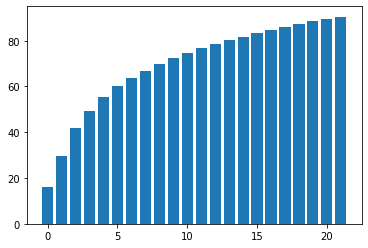

In [17]:
pca = PCA()
pca.fit_transform(X_train)

total = sum(pca.explained_variance_)
k = 0
current_variance = 0
while current_variance/total < 0.90: # less than 90% variance
    current_variance += pca.explained_variance_[k]
    k = k + 1
    
print(k, " features explain around 90% of the variance. From 7129 features to ", k, ", not too bad.", sep='')

pca = PCA(n_components=k)
X_train.pca = pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

var_exp = pca.explained_variance_ratio_.cumsum()
var_exp = var_exp*100
plt.bar(range(k), var_exp);

# Model Building

Having prepared the dataset, it's now finally time to try out some models.

**K-Means Clustering**

First we shall try an unsupervised clustering approach using the scaled data.

In [35]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X_train_scl)
km_pred = kmeans.predict(X_test_scl)


**Logistic Regression**

Another very standard approach is logistic regression. Here we will be using grid search cross-validation tuning to try and determine the best hyperparameters. We don't need to scale the data for logistic regression, nor are we using the PCA version of the dataset.

Best Parameters:
 {'C': 1, 'penalty': 'l1'}
Logistic Regression accuracy: 1.0


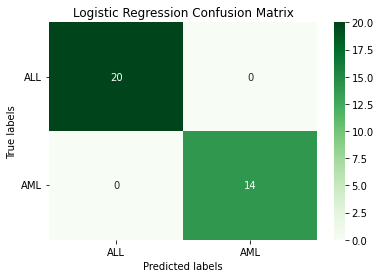

In [37]:
log_grid = {'C': [1e-03, 1e-2, 1e-1, 1, 10], 
                 'penalty': ['l1', 'l2']}

log_estimator = LogisticRegression(solver='liblinear')

log_model = GridSearchCV(estimator=log_estimator, 
                  param_grid=log_grid, 
                  cv=3,
                  scoring='accuracy')

log_model.fit(X_train, y_train.iloc[:,1])

print("Best Parameters:\n", log_model.best_params_)

# Select best log model
best_log = log_model.best_estimator_

# Make predictions using the optimised parameters
log_pred = best_log.predict(X_test)

print('Logistic Regression accuracy:', round(accuracy_score(y_test.iloc[:,1], log_pred), 3))

cm_log =  confusion_matrix(y_test.iloc[:,1], log_pred)

ax = plt.subplot()
sns.heatmap(cm_log, annot=True, ax = ax, fmt='g', cmap='Greens') 

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Logistic Regression Confusion Matrix') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

**Decision Tree**

Decision Tree accuracy: 0.912


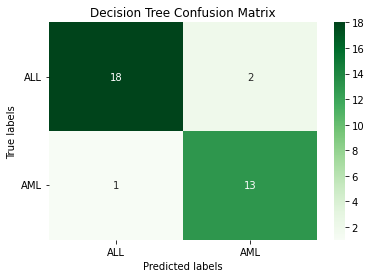

In [36]:
nb_model = GaussianNB()

nb_model.fit(X_train, y_train.iloc[:,1])
nb_pred = nb_model.predict(X_test)
cm_nb =  confusion_matrix(y_test.iloc[:,1], nb_pred)

# Create a Gaussian classifier
dt_model = DecisionTreeClassifier()

dt_model.fit(X_train, y_train.iloc[:,1])

dt_pred = dt_model.predict(X_test)

print('Decision Tree accuracy:', round(accuracy_score(y_test.iloc[:,1], dt_pred), 3))

cm_dt =  confusion_matrix(y_test.iloc[:,1], dt_pred)

ax = plt.subplot()

sns.heatmap(cm_nb, annot=True, ax = ax, fmt='g', cmap='Greens') 

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Decision Tree Confusion Matrix') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

**Random Forest**

We now move on to tree-base approaches, starting with the very popular random forest. We don't need scaled data for this, so again we wont use the scaled version of the dataset, just a grid search for tuning the hyperparameters.

Best Parameters:
 {'bootstrap': False, 'max_features': 0.6, 'min_samples_leaf': 8, 'min_samples_split': 3, 'n_estimators': 60}
Random Forest accuracy: 0.912


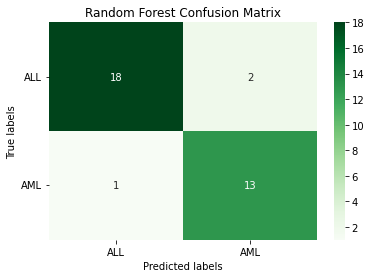

In [26]:
# Hyperparameters search grid 
rf_param_grid = {'bootstrap': [False, True],
         'n_estimators': [60, 70, 80, 90, 100],
         'max_features': [0.6, 0.65, 0.7, 0.75, 0.8],
         'min_samples_leaf': [8, 10, 12, 14],
         'min_samples_split': [3, 5, 7]
        }

# Instantiate random forest classifier
rf_estimator = RandomForestClassifier(random_state=0)

# Create the GridSearchCV object
rf_model = GridSearchCV(estimator=rf_estimator, param_grid=rf_param_grid, cv=3, scoring='accuracy')

# Fine-tune the hyperparameters
rf_model.fit(X_train, y_train.iloc[:,1])

print("Best Parameters:\n", rf_model.best_params_)

# Get the best model
rf_model_best = rf_model.best_estimator_

# Make predictions using the optimised parameters
rf_pred = rf_model_best.predict(X_test)

print('Random Forest accuracy:', round(accuracy_score(y_test.iloc[:,1], rf_pred), 3))

cm_rf = confusion_matrix(y_test.iloc[:,1], rf_pred)

ax = plt.subplot()
sns.heatmap(cm_rf, annot=True, ax = ax, fmt='g', cmap='Greens') 

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Random Forest Confusion Matrix') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);